In [1]:
import sys, os
os.environ['WANDB_NOTEBOOK_NAME'] = 'rbig_v2'
sys.path.append("/home/emmanuel/code/destructive-deep-learning")
# sys.path.append("/home/emmanuel/notebooks/jaxflows/scripts")

# from data import get_toy_data
# from visualize import plot_joint
from ddl.univariate import HistogramUnivariateDensity
from ddl.independent import (
    IndependentInverseCdf,
    IndependentDensity,
    IndependentDestructor,
)
from ddl.rbig import get_rbig_model
from ddl.linear import LinearProjector
from ddl.base import CompositeDestructor
from ddl.deep import DeepDestructor, DeepDestructorCV
from sklearn.decomposition import PCA
import tqdm
import wandb
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
# sns.set_style(style="white")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Logger

In [2]:
wandb.init(project="rbig4eo-demo", entity="emanjohnson91")
wandb.config.dataset = "sinewave"
wandb.config.n_samples = 10_000
wandb.config.n_synth = 5_000
wandb.config.alpha = 1e-5
wandb.config.rotation = "pca"
wandb.config.threshold = 0.25
wandb.config.stopping_crit = "info"
wandb.config.tol_layers = 15
wandb.config.seed = 123
wandb.config.tol_layers = 15
wandb.config.bounds = 0.1
wandb.config.bins = "sqrt"

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Data

In [3]:
rng = np.random.RandomState(wandb.config.seed)



def get_toy_data(n_samples=1000, seed=123):
    rng = np.random.RandomState(seed=seed)

    x = np.abs(2 * rng.randn(n_samples, 1))
    y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
    data = np.hstack((x, y))

    return data


In [4]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
rng = np.random.RandomState(seed=123)
n_samples = 10000
x = stats.beta.rvs(2, 10, size=(n_samples,1))
x = MinMaxScaler((-1, 8)).fit_transform(x)
y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
data = np.hstack((x, y))

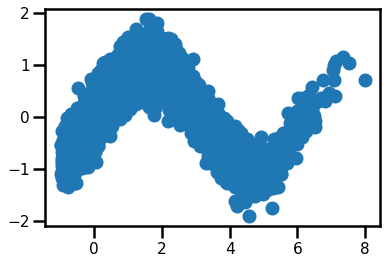

In [5]:
plt.scatter(x, y)

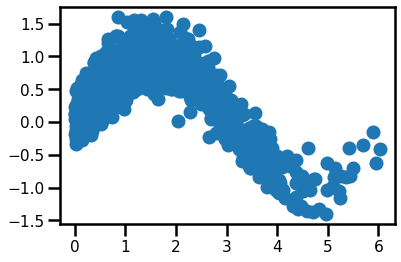

In [6]:
n_samples = 1000
x = np.abs(2 * rng.randn(n_samples, 1))
y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
plt.scatter(x, y)

In [7]:
data = get_toy_data(wandb.config.n_samples, wandb.config.seed)

In [8]:
data[:, 0].min(), data[:, 1].max()

(0.00015105322123091746, 1.8605093795883567)

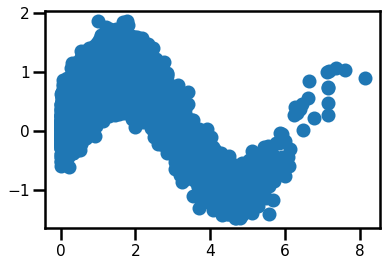

In [9]:
plt.scatter(data[:, 0], data[:, 1])

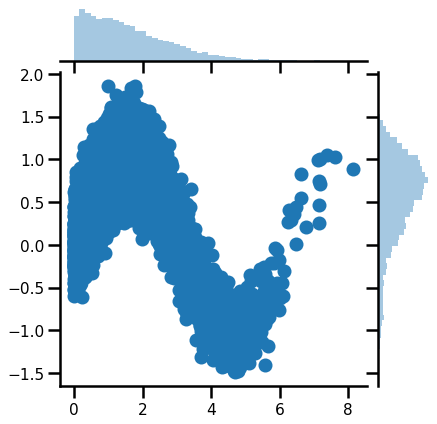

In [10]:
sns.jointplot(data[:, 0], data[:, 1])

## Plots

### Plot 1 - Original Domain

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


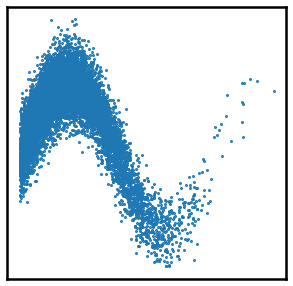

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:, 0], data[:, 1], s=1)
# ax.set_xlabel('X')
# ax.set_xlim([0, 8])
# ax.set_ylabel('Y')
# ax.set_ylim([-4, 4])
# ax.set_title('Original Data')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)
wandb.log({"original": wandb.Image(plt)})
plt.show()

## RBIG Model

In [12]:
rbig_flow = get_rbig_model(
    bins=wandb.config.bins, 
    bounds=0.3, 
    alpha=1e-5, 
    random_state=wandb.config.seed,
    rotation=wandb.config.rotation,
    tol_layers=60, 
    threshhold=wandb.config.threshold
)

In [13]:
wandb.config.threshold

0.25

In [14]:
X_g = rbig_flow.fit_transform(data)

### Gaussian Domain

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


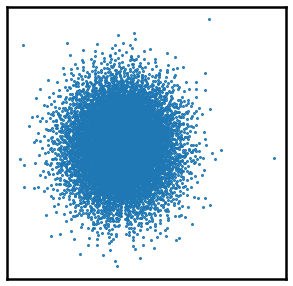

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_g[:, 0], X_g[:, 1], s=1)
# ax.set_xlabel('X')
# ax.set_xlim([0, 8])
# ax.set_ylabel('Y')
# ax.set_ylim([-4, 4])
# ax.set_title('Original Data')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)
wandb.log({"gaussianized": wandb.Image(plt)})
plt.show()

### Original Domain

In [16]:
data_approx = rbig_flow.inverse_transform(X_g)

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


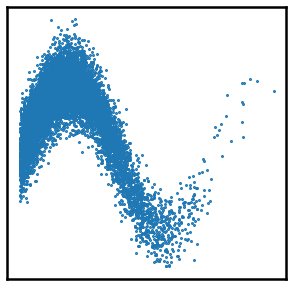

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data_approx[:, 0], data_approx[:, 1], s=1)
# ax.set_xlabel('X')
# # ax.set_xlim([0, 8])
# ax.set_ylabel('Y')
# ax.set_ylim([-4, 4])
# ax.set_title('Original Data')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)
# ax.set_aspect(aspect='equal')
wandb.log({"inverse": wandb.Image(plt)})
plt.show()

### Synthetic Data

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


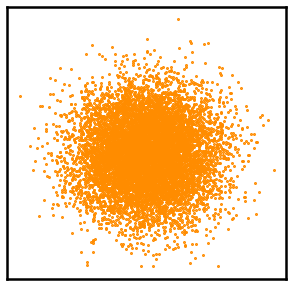

In [18]:

data_synth = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data_synth[:, 0], data_synth[:, 1], s=1, c='darkorange')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)
# ax.set_aspect(aspect='equal')
# plt.savefig(FIG_PATH.joinpath('base_gen.png'), frameon=False)
wandb.log({"rand_samples": wandb.Image(plt)})
plt.show()

In [19]:
data_original_synth = rbig_flow.inverse_transform(data_synth)

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


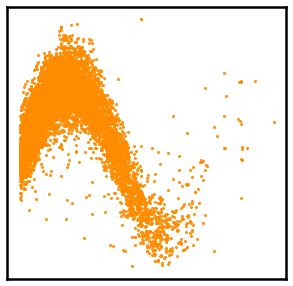

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
# ax.scatter(data[:, 0], data[:, 1], s=1)
ax.scatter(data_original_synth[:, 0], data_original_synth[:, 1], s=1, c='darkorange')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)
# ax.set_aspect(aspect='equal')
# plt.savefig(FIG_PATH.joinpath('generated.png'), frameon=False)
wandb.log({"synthesized": wandb.Image(plt)})
plt.show()

## Information Reduction

In [21]:
info_loss = rbig_flow.loss

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


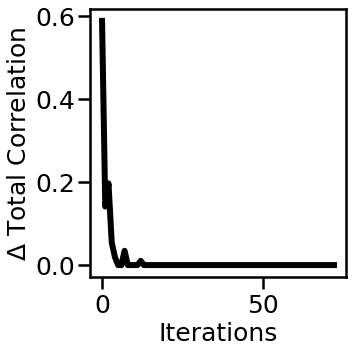

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(info_loss, color='black', linewidth=6)
ax.set_xlabel('Iterations', fontsize=25)
ax.set_ylabel(r"$\Delta$ Total Correlation", fontsize=25)
#     xlabel=,
#     ylabel=r"$\Delta$T",
# #     fontsize=20
# )
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=25,
    
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False
)
# ax.set_aspect(aspect='equal')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
wandb.log({"tc": wandb.Image(plt)})
plt.show()

## Non-Gaussianity

In [23]:
from scipy import stats

def neg_entropy_normal(data):
    """Function to calculate the marginal negative entropy 
    (negative entropy per dimensions). It uses a histogram
    scheme to initialize the bins and then uses a KDE 
    scheme to approximate a smooth solution.
    
    Parameters
    ----------
    data : array, (samples x dimensions)
    
    Returns
    -------
    neg : array, (dimensions)
    
    """

    n_samples, d_dimensions = data.shape

    # bin estimation
    # TODO: Use function
    n_bins = int(np.ceil(np.sqrt(n_samples)))

    neg = np.zeros(d_dimensions)

    # Loop through dimensions
    for idim in range(d_dimensions):

        # =====================
        # Histogram Estimation
        # =====================

        # Get Histogram
        [hist_counts, bin_edges] = np.histogram(
            a=data[:, idim],
            bins=n_bins,
            range=(data[:, idim].min(), data[:, idim].max()),
        )

        # calculate bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # get delta between bin centers
        delta = bin_centers[3] - bin_centers[2]

        # Calculate probabilities of normal distribution
        pg = stats.norm.pdf(bin_centers, 0, 1)

        # ==================
        # KDE Function Est.
        # ==================

        # Initialize KDE function with data
        kde_model = stats.gaussian_kde(data[:, idim])

        # Calculate probabilities for each bin
        hx = kde_model.pdf(bin_centers)

        # Calculate probabilities
        px = hx / (hx.sum() * delta)

        # ====================
        # Compare
        # ====================

        # Find the indices greater than zero
        idx = np.where((px > 0) & (pg > 0))

        # calculate the negative entropy
        neg[idim] = delta * (px[idx] * np.log2(px[idx] / pg[idx])).sum()

    return neg


In [24]:
%%time
nongauss_loss = []

Z = data.copy()


for i, iblock in enumerate(rbig_flow.fitted_destructors_):
    
    
    Z = iblock.transform(Z)
    
        
    # calculate the negative log-likelihood
    if (i+1) % 3 == 0:
        

        # add non-Gaussianity
        nongauss_loss.append(neg_entropy_normal(Z))

CPU times: user 25.7 s, sys: 1.93 s, total: 27.6 s
Wall time: 5.61 s


In [25]:
nongauss_loss = np.array(nongauss_loss).sum(axis=1)

[]

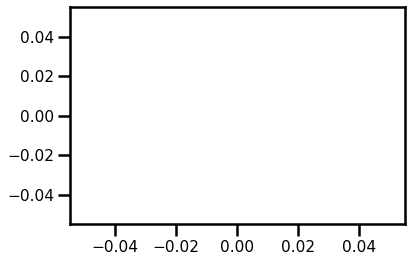

In [26]:
plt.plot()

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


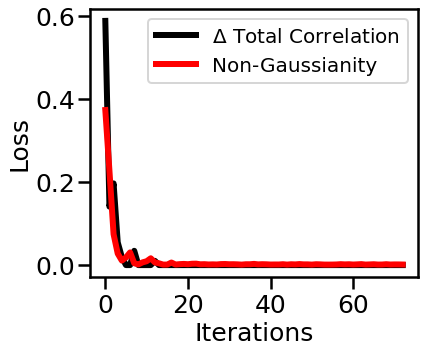

In [27]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(info_loss, 
        color='black', linewidth=6,
        label=r"$\Delta$ Total Correlation"
       )
ax.plot(nongauss_loss, 
        color='red', linestyle="-", linewidth=6,
        label=r"Non-Gaussianity"
       )
ax.set_xlabel('Iterations', fontsize=25)
ax.set_ylabel(r"Loss", fontsize=25)
#     xlabel=,
#     ylabel=r"$\Delta$T",
# #     fontsize=20
# )
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=25,
    
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False
)
# ax.set_aspect(aspect='equal')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9])
plt.legend(fontsize=20)


plt.tight_layout()
wandb.log({"losses": wandb.Image(plt)})
plt.show()

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


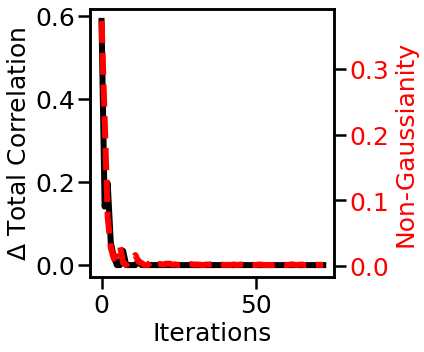

In [28]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(info_loss, color='black', linewidth=6)
ax.set_xlabel('Iterations', fontsize=25)
ax.set_ylabel(r"$\Delta$ Total Correlation", fontsize=25)
#     xlabel=,
#     ylabel=r"$\Delta$T",
# #     fontsize=20
# )
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=25,
    )
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Non-Gaussianity', color=color, fontsize=25)  # we already handled the x-label with ax1
ax2.plot(nongauss_loss, color='red', linestyle="--", linewidth=6)
ax2.tick_params(axis='y', labelcolor=color,)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelsize=25,
    
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False
)
# ax.set_aspect(aspect='equal')
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_yticklabels([0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
wandb.log({"losses_twin": wandb.Image(plt)})
plt.show()